In [120]:
from socceraction.data.wyscout import PublicWyscoutLoader
from socceraction.spadl.wyscout import convert_to_actions
from socceraction.data.opta import OptaLoader
from socceraction.data.statsbomb import StatsBombLoader
from socceraction.spadl.config import actiontypes, bodyparts
import socceraction.spadl as spadl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error
from xgboost import XGBClassifier, XGBRegressor
import math
import pickle
from mplsoccer import Pitch
import hashlib
import copy
import random
from os import system
import shap

In [121]:
# IMPORTANT CONSTANTS FOR THIS CODE SNIPPET
# COLUMNS_XPASS_MODEL = ["start_x", "start_y", "end_x", "end_y", "distance_pass", "distance_sideline", 
#                         "distance_goal", "distance_receiver_sideline", "distance_receiver_goal", "angle_pass", 
#                         "distance_opponent", "num_opponent_closer_goal", "distance_receiver_opponent", "num_opponent_closer_goal_receiver", 
#                         "num_opponent_in_path", "num_opponent_in_path_receiver"]
COLUMNS_XPASS_MODEL = ["distance_pass", "num_opponent_in_path", "num_opponent_in_path_receiver",
                        "num_opponent_0_and_45_before_midpoint_actor",
                        "num_opponent_0_and_45_after_midpoint_actor",
                        # "num_opponent_45_and_90_before_midpoint_actor",
                        # "num_opponent_45_and_90_after_midpoint_actor",
                        # "num_opponent_90_and_135_before_midpoint_actor",
                        # "num_opponent_90_and_135_after_midpoint_actor",
                        # "num_opponent_135_and_180_before_midpoint_actor",
                        # "num_opponent_135_and_180_after_midpoint_actor",
                        "num_opponent_0_and_45_before_midpoint_receiver",
                        "num_opponent_0_and_45_after_midpoint_receiver",
                        # "num_opponent_45_and_90_before_midpoint_receiver",
                        # "num_opponent_45_and_90_after_midpoint_receiver",
                        # "num_opponent_90_and_135_before_midpoint_receiver",
                        # "num_opponent_90_and_135_after_midpoint_receiver",
                        # "num_opponent_135_and_180_before_midpoint_receiver",
                        # "num_opponent_135_and_180_after_midpoint_receiver"
                        ]
COLUMNS_XGOAL_MODEL = ["start_x", "start_y", "distance_to_goal", "angle_to_goal", "distance_opponent", 
                       "num_opponent_closer_goal", "num_opponent_in_path"]
COLUMNS_PLAYERS_SKILL = ["acceleration", "aggression", "agility", "balance", "ball_control",
                        "composure", "crossing", "curve", "dribbling", "finishing",
                        "freekick_accuracy", "heading_accuracy", "interceptions", "jumping", "long_passing",
                        "long_shots", "marking", "penalties", "positioning", "reactions",
                        "shot_power", "sliding_tackle", "sprint_speed", "stamina", "short_passing",
                        "standing_tackle", "strength", "vision", "volleys"]
COLUMNS_XDRIBBLE_MODEL = ["start_x", "start_y", "end_x", "end_y", "distance_opponent", 
                            "num_opponent_closer_goal", "num_opponent_in_path"]
COLUMNS_PLAYERS_ATTRIBUTE = ["height_cm", "weight_kgs", "age"]

STANDARD_LENGTH_COURT = 105
STANDARD_WIDTH_COURT = 68
STANDARD_GOALLINE_WIDTH = 7.32
STANDARD_LENGTH_COURT_STATSBOMB = 120
STANDARD_WIDTH_COURT_STATSBOMB = 80
IS_HOME_TEAM_DIRECTION = True
INCLUDE_SKILL = False
INCLUDE_OPPONENT = True

# # TESTING PURPOSE
# INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/input_coordinate_player.csv"
# # INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/input_coordinate_player_many_opponent.csv"
# INPUT_PLAYER_SKILL_FILE_CSV_PATH = 'data/input_decision_making_model/input_skill_player.csv'
# INPUT_PLAYER_ATTRIBUTE_FILE_CSV_PATH = 'data/input_decision_making_model/input_attribute_player.csv'

# ============================================================================================================================

# # REAL TEST SCENARIO : ARGENTINA SUCCESS SCHEME (WORLD CUP 2022)
# INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/real_test/argentina_vs_france_2022_success_case_coordinate_input.csv"
# INPUT_PLAYER_SKILL_FILE_CSV_PATH = 'data/input_decision_making_model/real_test/argentina_vs_france_2022_success_case_skill_player.csv'
# INPUT_PLAYER_ATTRIBUTE_FILE_CSV_PATH = 'data/input_decision_making_model/real_test/argentina_vs_france_2022_success_case_attribute_player.csv'

# # REAL TEST SCENARIO : ARGENTINA SUCCESS SCHEME (WORLD CUP 2022) --> SKILL SCORE HIGHER 20
# INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/real_test/argentina_vs_france_2022_success_case_coordinate_input.csv"
# INPUT_PLAYER_SKILL_FILE_CSV_PATH = 'data/input_decision_making_model/player_skill_sensitivity_test/world_cup_2022_success_case_higher_20.csv'
# INPUT_PLAYER_ATTRIBUTE_FILE_CSV_PATH = 'data/input_decision_making_model/real_test/argentina_vs_france_2022_success_case_attribute_player.csv'

# # REAL TEST SCENARIO : ARGENTINA SUCCESS SCHEME (WORLD CUP 2022) --> SKILL SCORE LOWER 20
# INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/real_test/argentina_vs_france_2022_success_case_coordinate_input.csv"
# INPUT_PLAYER_SKILL_FILE_CSV_PATH = 'data/input_decision_making_model/player_skill_sensitivity_test/world_cup_2022_success_case_lower_20.csv'
# INPUT_PLAYER_ATTRIBUTE_FILE_CSV_PATH = 'data/input_decision_making_model/real_test/argentina_vs_france_2022_success_case_attribute_player.csv'

# ============================================================================================================================

# # REAL TEST SCENARIO : ARGENTINA FAIL SCHEME (WORLD CUP 2022)
# INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/real_test/argentina_vs_france_2022_fail_case_coordinate_input.csv"
# INPUT_PLAYER_SKILL_FILE_CSV_PATH = 'data/input_decision_making_model/real_test/argentina_vs_france_2022_fail_case_skill_player.csv'
# INPUT_PLAYER_ATTRIBUTE_FILE_CSV_PATH = 'data/input_decision_making_model/real_test/argentina_vs_france_2022_fail_case_attribute_player.csv'

# # REAL TEST SCENARIO : ARGENTINA FAIL SCHEME (WORLD CUP 2022) --> SKILL SCORE HIGHER 20
# INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/real_test/argentina_vs_france_2022_fail_case_coordinate_input.csv"
# INPUT_PLAYER_SKILL_FILE_CSV_PATH = 'data/input_decision_making_model/player_skill_sensitivity_test/world_cup_2022_fail_case_higher_20.csv'
# INPUT_PLAYER_ATTRIBUTE_FILE_CSV_PATH = 'data/input_decision_making_model/real_test/argentina_vs_france_2022_fail_case_attribute_player.csv'

# # REAL TEST SCENARIO : ARGENTINA FAIL SCHEME (WORLD CUP 2022) --> SKILL SCORE LOWER 20
# INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/real_test/argentina_vs_france_2022_fail_case_coordinate_input.csv"
# INPUT_PLAYER_SKILL_FILE_CSV_PATH = 'data/input_decision_making_model/player_skill_sensitivity_test/world_cup_2022_fail_case_lower_20.csv'
# INPUT_PLAYER_ATTRIBUTE_FILE_CSV_PATH = 'data/input_decision_making_model/real_test/argentina_vs_france_2022_fail_case_attribute_player.csv'

# ============================================================================================================================

# # REAL TEST SCENARIO : ITALY SUCCESS SCHEME (EURO 2020)
# INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/real_test/italy_vs_austria_2020_success_case_coordinate_input.csv"
# INPUT_PLAYER_SKILL_FILE_CSV_PATH = 'data/input_decision_making_model/real_test/italy_vs_austria_2020_success_case_skill_player.csv'
# INPUT_PLAYER_ATTRIBUTE_FILE_CSV_PATH = 'data/input_decision_making_model/real_test/italy_vs_austria_2020_success_case_attribute_player.csv'

# # REAL TEST SCENARIO : ITALY SUCCESS SCHEME (EURO 2020) --> SKILL SCORE HIGHER 20
# INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/real_test/italy_vs_austria_2020_success_case_coordinate_input.csv"
# INPUT_PLAYER_SKILL_FILE_CSV_PATH = 'data/input_decision_making_model/player_skill_sensitivity_test/euro_2020_success_case_higher_20.csv'
# INPUT_PLAYER_ATTRIBUTE_FILE_CSV_PATH = 'data/input_decision_making_model/real_test/italy_vs_austria_2020_success_case_attribute_player.csv'

# # REAL TEST SCENARIO : ITALY SUCCESS SCHEME (EURO 2020) --> SKILL SCORE LOWER 20
# INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/real_test/italy_vs_austria_2020_success_case_coordinate_input.csv"
# INPUT_PLAYER_SKILL_FILE_CSV_PATH = 'data/input_decision_making_model/player_skill_sensitivity_test/euro_2020_success_case_lower_20.csv'
# INPUT_PLAYER_ATTRIBUTE_FILE_CSV_PATH = 'data/input_decision_making_model/real_test/italy_vs_austria_2020_success_case_attribute_player.csv'

# ============================================================================================================================

# # REAL TEST SCENARIO : ITALY FAIL SCHEME (EURO 2020)
# INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/real_test/italy_vs_austria_2020_fail_case_coordinate_input.csv"
# INPUT_PLAYER_SKILL_FILE_CSV_PATH = 'data/input_decision_making_model/real_test/italy_vs_austria_2020_fail_case_skill_player.csv'
# INPUT_PLAYER_ATTRIBUTE_FILE_CSV_PATH = 'data/input_decision_making_model/real_test/italy_vs_austria_2020_fail_case_attribute_player.csv'

# # REAL TEST SCENARIO : ITALY FAIL SCHEME (EURO 2020) --> SKILL SCORE HIGHER 20
# INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/real_test/italy_vs_austria_2020_fail_case_coordinate_input.csv"
# INPUT_PLAYER_SKILL_FILE_CSV_PATH = 'data/input_decision_making_model/player_skill_sensitivity_test/euro_2020_fail_case_higher_20.csv'
# INPUT_PLAYER_ATTRIBUTE_FILE_CSV_PATH = 'data/input_decision_making_model/real_test/italy_vs_austria_2020_fail_case_attribute_player.csv'

# # REAL TEST SCENARIO : ITALY FAIL SCHEME (EURO 2020) --> SKILL SCORE LOWER 20
# INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/real_test/italy_vs_austria_2020_fail_case_coordinate_input.csv"
# INPUT_PLAYER_SKILL_FILE_CSV_PATH = 'data/input_decision_making_model/player_skill_sensitivity_test/euro_2020_fail_case_lower_20.csv'
# INPUT_PLAYER_ATTRIBUTE_FILE_CSV_PATH = 'data/input_decision_making_model/real_test/italy_vs_austria_2020_fail_case_attribute_player.csv'

In [122]:
# # LOCATION SENSITIVITY TEST XPASS
# INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/location_sensitivity_test/input_xpass_with_opponent_2.csv"
# INPUT_PLAYER_SKILL_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_skill_player.csv'
# INPUT_PLAYER_ATTRIBUTE_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_attribute_player.csv'

# # LOCATION SENSITIVITY TEST XPASS (SKILL HIGHER 20)
# INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/location_sensitivity_test/input_xpass_with_opponent_2.csv"
# INPUT_PLAYER_SKILL_FILE_CSV_PATH = 'data/input_decision_making_model/player_skill_sensitivity_test/input_skill_player_higher_20.csv'
# INPUT_PLAYER_ATTRIBUTE_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_attribute_player.csv'

# # LOCATION SENSITIVITY TEST XPASS (SKILL LOWER 20)
# INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/location_sensitivity_test/input_xpass_with_opponent_2.csv"
# INPUT_PLAYER_SKILL_FILE_CSV_PATH = 'data/input_decision_making_model/player_skill_sensitivity_test/input_skill_player_lower_20.csv'
# INPUT_PLAYER_ATTRIBUTE_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_attribute_player.csv'

# # LOCATION SENSITIVITY TEST XPASS (ROTATE OPPONENT 30 DEGREES LEFT)
# INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/location_sensitivity_test/input_xpass_with_opponent_rotate_30_left_2.csv"
# INPUT_PLAYER_SKILL_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_skill_player.csv'
# INPUT_PLAYER_ATTRIBUTE_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_attribute_player.csv'

# # LOCATION SENSITIVITY TEST XPASS (ROTATE OPPONENT 30 DEGREES RIGHT)
# INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/location_sensitivity_test/input_xpass_with_opponent_rotate_30_right_2.csv"
# INPUT_PLAYER_SKILL_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_skill_player.csv'
# INPUT_PLAYER_ATTRIBUTE_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_attribute_player.csv'

# # LOCATION SENSITIVITY TEST XPASS (ROTATE OPPONENT 180 DEGREES)
# INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/location_sensitivity_test/input_xpass_with_opponent_2_rotate_180.csv"
# INPUT_PLAYER_SKILL_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_skill_player.csv'
# INPUT_PLAYER_ATTRIBUTE_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_attribute_player.csv'

# # LOCATION SENSITIVITY TEST XPASS (SHORTER_DISTANCE)
# INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/location_sensitivity_test/input_xpass_with_opponent_2_shorter_distance.csv"
# INPUT_PLAYER_SKILL_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_skill_player.csv'
# INPUT_PLAYER_ATTRIBUTE_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_attribute_player.csv'

# LOCATION SENSITIVITY TEST XPASS (MANY OPPONENT BLOCKING PATH SURROUNDING)
INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/location_sensitivity_test/input_xpass_many_opponent_block_path.csv"
INPUT_PLAYER_SKILL_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_skill_player.csv'
INPUT_PLAYER_ATTRIBUTE_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_attribute_player.csv'

# # LOCATION SENSITIVITY TEST XPASS (MANY OPPONENT NON BLOCKING PATH SURROUNDING)
# INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/location_sensitivity_test/input_xpass_many_opponent_non_block_path.csv"
# INPUT_PLAYER_SKILL_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_skill_player.csv'
# INPUT_PLAYER_ATTRIBUTE_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_attribute_player.csv'

# ================================================================================================================================

# # LOCATION SENSITIVITY TEST XDRIBBLE
# INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/location_sensitivity_test/input_xdribble_with_opponent_2.csv"
# INPUT_PLAYER_SKILL_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_skill_player.csv'
# INPUT_PLAYER_ATTRIBUTE_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_attribute_player.csv'

# # LOCATION SENSITIVITY TEST XDRIBBLE (SKILL HIGHER 20)
# INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/location_sensitivity_test/input_xdribble_with_opponent_2.csv"
# INPUT_PLAYER_SKILL_FILE_CSV_PATH = 'data/input_decision_making_model/player_skill_sensitivity_test/input_skill_player_higher_20.csv'
# INPUT_PLAYER_ATTRIBUTE_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_attribute_player.csv'

# # LOCATION SENSITIVITY TEST XDRIBBLE (SKILL LOWER 20)
# INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/location_sensitivity_test/input_xdribble_with_opponent_2.csv"
# INPUT_PLAYER_SKILL_FILE_CSV_PATH = 'data/input_decision_making_model/player_skill_sensitivity_test/input_skill_player_lower_20.csv'
# INPUT_PLAYER_ATTRIBUTE_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_attribute_player.csv'

# # LOCATION SENSITIVITY TEST XDRIBBLE (ROTATE OPPONENT 30 DEGREES LEFT)
# INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/location_sensitivity_test/input_xdribble_with_opponent_rotate_30_left_2.csv"
# INPUT_PLAYER_SKILL_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_skill_player.csv'
# INPUT_PLAYER_ATTRIBUTE_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_attribute_player.csv'

# # LOCATION SENSITIVITY TEST XDRIBBLE (ROTATE OPPONENT 30 DEGREES RIGHT)
# INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/location_sensitivity_test/input_xdribble_with_opponent_rotate_30_right_2.csv"
# INPUT_PLAYER_SKILL_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_skill_player.csv'
# INPUT_PLAYER_ATTRIBUTE_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_attribute_player.csv'

# # LOCATION SENSITIVITY TEST XDRIBBLE (ROTATE OPPONENT 180 DEGREES)
# INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/location_sensitivity_test/input_xdribble_with_opponent_2_rotate_180.csv"
# INPUT_PLAYER_SKILL_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_skill_player.csv'
# INPUT_PLAYER_ATTRIBUTE_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_attribute_player.csv'

# # LOCATION SENSITIVITY TEST XDRIBBLE (SHORTER_DISTANCE)
# INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/location_sensitivity_test/input_xdribble_with_opponent_2_shorter_distance.csv"
# INPUT_PLAYER_SKILL_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_skill_player.csv'
# INPUT_PLAYER_ATTRIBUTE_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_attribute_player.csv'

# ================================================================================================================================

# # LOCATION SENSITIVITY TEST XGOAL
# INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/location_sensitivity_test/input_xgoal_with_opponent_2.csv"
# INPUT_PLAYER_SKILL_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_skill_player.csv'
# INPUT_PLAYER_ATTRIBUTE_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_attribute_player.csv'

# # LOCATION SENSITIVITY TEST XGOAL (SKILL HIGHER 20)
# INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/location_sensitivity_test/input_xgoal_with_opponent_2.csv"
# INPUT_PLAYER_SKILL_FILE_CSV_PATH = 'data/input_decision_making_model/player_skill_sensitivity_test/input_skill_player_higher_20.csv'
# INPUT_PLAYER_ATTRIBUTE_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_attribute_player.csv'

# # LOCATION SENSITIVITY TEST XGOAL (SKILL LOWER 20)
# INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/location_sensitivity_test/input_xgoal_with_opponent_2.csv"
# INPUT_PLAYER_SKILL_FILE_CSV_PATH = 'data/input_decision_making_model/player_skill_sensitivity_test/input_skill_player_lower_20.csv'
# INPUT_PLAYER_ATTRIBUTE_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_attribute_player.csv'

# # LOCATION SENSITIVITY TEST XGOAL (ROTATE OPPONENT 30 DEGREES LEFT)
# INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/location_sensitivity_test/input_xgoal_with_opponent_rotate_30_left_2.csv"
# INPUT_PLAYER_SKILL_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_skill_player.csv'
# INPUT_PLAYER_ATTRIBUTE_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_attribute_player.csv'

# # LOCATION SENSITIVITY TEST XGOAL (ROTATE OPPONENT 30 DEGREES RIGHT)
# INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/location_sensitivity_test/input_xgoal_with_opponent_rotate_30_right_2.csv"
# INPUT_PLAYER_SKILL_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_skill_player.csv'
# INPUT_PLAYER_ATTRIBUTE_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_attribute_player.csv'

# # LOCATION SENSITIVITY TEST XGOAL (ROTATE OPPONENT 180 DEGREES)
# INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/location_sensitivity_test/input_xgoal_with_opponent_2_rotate_180.csv"
# INPUT_PLAYER_SKILL_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_skill_player.csv'
# INPUT_PLAYER_ATTRIBUTE_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_attribute_player.csv'

# # LOCATION SENSITIVITY TEST XGOAL (SHORTER_DISTANCE)
# INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/location_sensitivity_test/input_xgoal_with_opponent_2_shorter_distance.csv"
# INPUT_PLAYER_SKILL_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_skill_player.csv'
# INPUT_PLAYER_ATTRIBUTE_FILE_CSV_PATH = 'data/input_decision_making_model/location_sensitivity_test/input_attribute_player.csv'

In [123]:
# ALL HELPER FUNCTIONS
# Load Model from External Directory
def load_model_from_external_file_pickle(filename_path):
    return pickle.load(open(filename_path, 'rb'))

# Load Pandas Dataframe from external csv file
def load_pandas_dataframe_from_csv(filename_path, delimiter=","):
    return pd.read_csv(filename_path, delimiter=delimiter)

# Xpass : Helper to calculate nearest distance from sideline given coordinate
def calculate_nearest_distance_from_sideline(coordinate_x, coordinate_y):
    distance_to_left = coordinate_x
    distance_to_bottom = coordinate_y
    distance_to_top = STANDARD_WIDTH_COURT - coordinate_y
    distance_to_right = STANDARD_LENGTH_COURT - coordinate_x
    return min(distance_to_top, distance_to_bottom, distance_to_left, distance_to_right)

# Xpass : Helper to calculate distance with opposing goal given coordinate
def calculate_distance_with_opposing_goal(coordinate_x, coordinate_y, is_home_team):
    distance_vertical = abs((STANDARD_WIDTH_COURT / 2) - coordinate_y)
    if (is_home_team):
        distance_horizontal = STANDARD_LENGTH_COURT - coordinate_x
    else:
        distance_horizontal = coordinate_x
    return math.sqrt(distance_vertical ** 2 + distance_horizontal ** 2)

# Xpass or Xdribble : Helper to calculate distance between two coordinates (x1,y1) and (x2,y2)
def calculate_distance_between_two_coordinates(x1, y1, x2, y2):
    return math.sqrt(abs(x2-x1) ** 2 + abs(y2-y1) ** 2)

# Xpass : Helper to calculate angle between passer and receiver
def calculate_angle_pass(coordinate_x, coordinate_y, end_x, end_y, is_home_team):
    if (is_home_team):
        coordinate_x_goal = STANDARD_LENGTH_COURT
    else:
        coordinate_x_goal = 0
    coordinate_y_goal = STANDARD_WIDTH_COURT / 2

    distance_passer_to_goal = calculate_distance_between_two_coordinates(coordinate_x_goal, coordinate_y_goal, coordinate_x, coordinate_y)
    distance_receiver_to_goal = calculate_distance_between_two_coordinates(coordinate_x_goal, coordinate_y_goal, end_x, end_y)
    distance_passer_to_receiver = calculate_distance_between_two_coordinates(coordinate_x, coordinate_y, end_x, end_y)

    if (coordinate_x == end_x) and (coordinate_y == end_y):
        return 0
    else:
        cosine_value = (distance_passer_to_goal ** 2 + distance_passer_to_receiver ** 2 - distance_receiver_to_goal ** 2) / (2 * distance_passer_to_goal * distance_passer_to_receiver)
        if (cosine_value > 1):
            cosine_value = 1
        elif (cosine_value < -1):
            cosine_value = -1
        return math.degrees(math.acos(cosine_value))
    
# Opponent Feature : Calculate nearest opponent distance
def calculate_distance_opponent(start_x, start_y, list_node_opponents):
    list_distance_opponent = []
    for opponent_obj in list_node_opponents:
        opponent_x, opponent_y = opponent_obj.get_coordinate_value()
        distance_opponent = calculate_distance_between_two_coordinates(start_x, start_y, opponent_x, opponent_y)
        list_distance_opponent.append(distance_opponent)
    return min(list_distance_opponent) if len(list_distance_opponent) > 0 else 0

# Opponent Feature : Calculate number of opponents closer to goal
def calculate_num_opponent_closer_goal(start_x, start_y, list_node_opponents, is_home_team):
    if (is_home_team):
        coordinate_x_goal = STANDARD_LENGTH_COURT
    else:
        coordinate_x_goal = 0
    coordinate_y_goal = STANDARD_WIDTH_COURT / 2

    num_opponent_closer_to_goal = 0
    for opponent_obj in list_node_opponents:
        opponent_x, opponent_y = opponent_obj.get_coordinate_value()
        distance_passer_to_goal = calculate_distance_between_two_coordinates(start_x, start_y, coordinate_x_goal, coordinate_y_goal)
        distance_opponent_to_goal = calculate_distance_between_two_coordinates(opponent_x, opponent_y, coordinate_x_goal, coordinate_y_goal)
        if (distance_opponent_to_goal < distance_passer_to_goal):
            num_opponent_closer_to_goal += 1
    return num_opponent_closer_to_goal

# Opponent Feature : calculate number of opponents in path distance (default 10 metres)
def calculate_num_opponent_in_path(start_x, start_y, list_node_opponents):
    path_distance = 10
    num_opponent_in_path = 0
    for opponent_obj in list_node_opponents:
        opponent_x, opponent_y = opponent_obj.get_coordinate_value()
        distance_with_opponent = calculate_distance_between_two_coordinates(start_x, start_y, opponent_x, opponent_y)
        if (distance_with_opponent <= path_distance):
            num_opponent_in_path += 1
    return num_opponent_in_path

# New Opponent Feature 1 : calculate number of opponents based on angle path
def calculate_num_opponent_based_on_angle_path_per_side(start_x, start_y, end_x, end_y, lower_limit_deg, upper_limit_deg, before_midpoint, opponent_x, opponent_y, is_actor_side):
    radius_path_length = calculate_distance_between_two_coordinates(start_x, start_y, end_x, end_y)
    if (is_actor_side):
        distance_with_opponent = calculate_distance_between_two_coordinates(start_x, start_y, opponent_x, opponent_y)
        distance_opponent_with_target = calculate_distance_between_two_coordinates(end_x, end_y, opponent_x, opponent_y)
    else:
        distance_with_opponent = calculate_distance_between_two_coordinates(end_x, end_y, opponent_x, opponent_y)
        distance_opponent_with_target = calculate_distance_between_two_coordinates(start_x, start_y, opponent_x, opponent_y)
    
    if (distance_opponent_with_target == 0) or (radius_path_length == 0):
        angle_opponent_with_path = 0
    else:
        cosine_value = (distance_with_opponent ** 2 + radius_path_length ** 2 - distance_opponent_with_target ** 2) / (2 * distance_with_opponent * radius_path_length)
        if (cosine_value > 1):
            cosine_value = 1
        elif (cosine_value < -1):
            cosine_value = -1
        angle_opponent_with_path = math.degrees(math.acos(cosine_value))

    num_opponent_in_this_angle = 0
    if (distance_with_opponent <= radius_path_length):
        if (before_midpoint and (distance_with_opponent <= (radius_path_length / 2))) or (not before_midpoint and (distance_with_opponent > (radius_path_length / 2))):
            if (angle_opponent_with_path == 0) and (upper_limit_deg == 45):
                num_opponent_in_this_angle += 1
            elif (angle_opponent_with_path > lower_limit_deg) and (angle_opponent_with_path <= upper_limit_deg):
                num_opponent_in_this_angle += 1
    return num_opponent_in_this_angle

def calculate_num_opponent_based_on_angle_path(start_x, start_y, end_x, end_y, lower_limit_deg, upper_limit_deg, before_midpoint, list_node_opponents, is_actor_side):
    num_opponent_in_this_angle = 0
    for opponent_obj in list_node_opponents:
        opponent_x, opponent_y = opponent_obj.get_coordinate_value()
        num_opponent_in_this_angle += calculate_num_opponent_based_on_angle_path_per_side(start_x, start_y, end_x, end_y, 
                                        lower_limit_deg, upper_limit_deg, before_midpoint, opponent_x, opponent_y, is_actor_side)
    return num_opponent_in_this_angle

# Xgoal : Helper to calculate distance to opponent's goal
def calculate_distance_to_goal(length_court, width_court, coordinate_x, coordinate_y, is_home_team):
    if is_home_team:
        distance_to_goal = math.sqrt((abs(length_court - coordinate_x)) ** 2 + (abs((0.5 * width_court) - coordinate_y)) ** 2)
    else:
        distance_to_goal = math.sqrt((coordinate_x) ** 2 + (abs((0.5 * width_court) - coordinate_y)) ** 2)
    return distance_to_goal

# Xgoal : Helper to calculate angle to opponent's goal
def calculate_angle_to_goal(goalline_width, length_court, width_court, coordinate_x, coordinate_y, is_home_team):
    if is_home_team:
        coordinate_x_post_1, coordinate_x_post_2 = (length_court, length_court)
    else:
        coordinate_x_post_1, coordinate_x_post_2 = (0, 0)
    coordinate_y_post_1 = (width_court / 2) + (goalline_width / 2)
    coordinate_y_post_2 = (width_court / 2) - (goalline_width / 2)

    distance_to_post_1 = math.sqrt(abs(coordinate_x - coordinate_x_post_1) ** 2 + abs(coordinate_y - coordinate_y_post_1) ** 2)
    distance_to_post_2 = math.sqrt(abs(coordinate_x - coordinate_x_post_2) ** 2 + abs(coordinate_y - coordinate_y_post_2) ** 2)

    return math.degrees(math.acos((distance_to_post_1 ** 2 + distance_to_post_2 ** 2 - goalline_width ** 2) / (2 * distance_to_post_1 * distance_to_post_2)))

In [124]:
# CLASS DATA STRUCTURE FOR STORING INFORMATION BASED ON INPUT
class Skill_Player_Values:
    def __init__(self, player_id):
        self.player_id = player_id
        self.attribute_values = {
            "height_cm" : 0,
            "weight_kgs" : 0,
            "age" : 0
        }
        self.skill_values = {
            "acceleration" : 0, "aggression" : 0, 
            "agility" : 0, "balance" : 0, 
            "ball_control" : 0,"composure" : 0, 
            "crossing" : 0, "curve" : 0, 
            "dribbling" : 0, "finishing" : 0,
            "freekick_accuracy" : 0, "heading_accuracy" : 0, 
            "interceptions" : 0, "jumping" : 0, 
            "long_passing" : 0, "long_shots" : 0, 
            "marking" : 0, "penalties" : 0, 
            "positioning" : 0, "reactions" : 0,
            "shot_power" : 0, "sliding_tackle" : 0, 
            "sprint_speed" : 0, "stamina" : 0, 
            "short_passing" : 0, "standing_tackle" : 0, 
            "strength" : 0, "vision" : 0, 
            "volleys" : 0
        }

    def get_player_id(self):
        return self.player_id
    
    def set_player_id(self, player_id):
        self.player_id = player_id

    def get_skill_value_by_key(self, key):
        return self.skill_values[key]
    
    def set_skill_value_by_key(self, key, score):
        self.skill_values[key] = score

    def get_attribute_value_by_key(self, key):
        return self.attribute_values[key]
    
    def set_attribute_value_by_key(self, key, score):
        self.attribute_values[key] = score

class Node_Decision_Making:
    def __init__(self, name, player_id, coordinate_x, coordinate_y, is_home_team):
        self.name = name
        self.player_id = player_id
        self.coordinate = (coordinate_x, coordinate_y)
        self.xgoal_value = None
        self.is_home_team = is_home_team
        self.skill_and_attributes_values = Skill_Player_Values(player_id) 
    
    def get_player_name(self):
        return self.name
    
    def set_player_name(self, name):
        self.name = name

    def get_player_id(self):
        return self.player_id
    
    def set_player_id(self, player_id):
        self.player_id = player_id
    
    def get_xgoal_value(self):
        return self.xgoal_value
    
    def set_xgoal_value(self, xgoal_value):
        self.xgoal_value = xgoal_value

    def get_coordinate_value(self):
        return self.coordinate
    
    def set_coordinate_value(self, coordinate_x, coordinate_y):
        self.coordinate = (coordinate_x, coordinate_y)

    def get_is_home_team(self):
        return self.is_home_team
    
    def set_is_home_team(self, is_home_team):
        self.is_home_team = is_home_team

    def get_skill_values(self):
        return self.skill_and_attributes_values
    
    def set_skill_values(self, object_skill_values):
        self.skill_and_attributes_values = object_skill_values

class Path_Decision_Making_Real:
    ACTION_TYPE_PASS = "pass"
    ACTION_TYPE_DRIBBLE = "dribble"
    ACTION_TYPE_SHOT = "shot"

    def __init__(self):
        self.route_path_per_timestamp_map = {}
        self.opponent_state_per_timestamp_map = {}

    def get_all_teammates_nodes_not_unique(self):
        list_node_teammates_not_unique = []
        sorted_timestamp_list = sorted(list(self.route_path_per_timestamp_map.keys()))
        timestamp_final = 0
        for idx in range(len(sorted_timestamp_list)):
            if (idx == len(sorted_timestamp_list)-1):
                timestamp_final = sorted_timestamp_list[idx]
            node_player_start = self.route_path_per_timestamp_map[sorted_timestamp_list[idx]]["source"]
            list_node_teammates_not_unique.append(node_player_start)
        node_player_end = self.route_path_per_timestamp_map[timestamp_final]["destination"]
        list_node_teammates_not_unique.append(node_player_end)
        return list_node_teammates_not_unique

    def get_route_path_per_timestamp_map(self):
        return self.route_path_per_timestamp_map

    def get_route_path_per_timestamp_map_by_key(self, key):
        return self.route_path_per_timestamp_map[key]
    
    def set_route_path_per_timestamp_map_by_key(self, key, key_route, value_route):
        self.route_path_per_timestamp_map[key][key_route] = value_route

    def get_opponent_state_per_timestamp_map(self):
        return self.opponent_state_per_timestamp_map

    def set_route_path_per_timestamp_element(self, timestamp, node_source, node_target):
        player_id_src = node_source.get_player_id()
        player_id_target = node_target.get_player_id()
        action_type = Path_Decision_Making_Real.ACTION_TYPE_PASS \
                        if player_id_src != player_id_target \
                        else Path_Decision_Making_Real.ACTION_TYPE_DRIBBLE
        self.route_path_per_timestamp_map[timestamp] = {
            "source" : node_source,
            "destination" : node_target,
            "action_type" : action_type,
            "pass_or_dribble_prop": 0.0
        }

    def set_opponent_state_per_timestamp_element(self, timestamp, opponent_node_list):
        self.opponent_state_per_timestamp_map[timestamp] = opponent_node_list

In [125]:
def construct_simple_maps_for_path_route_from_input(df_coordinate_player_teammates):
    unique_timestamp_teammates = sorted(df_coordinate_player_teammates['timestamp'].unique())
    simple_maps_path_route = {}
    stop_this_loop = False
    print("Please choose the desired corresponding routes.")
    for timestamp in unique_timestamp_teammates:
        df_these_players_timestamp = df_coordinate_player_teammates[df_coordinate_player_teammates['timestamp'] == timestamp]
        player_ids_this_timestamp = df_these_players_timestamp['player_id'].unique()
        request_input_stop = False
        while (not request_input_stop):
            try:
                print(f'\nChoose one of these player(s) for timestamp {timestamp} - Type correct player id number')
                for _, df_row_player in df_these_players_timestamp.iterrows():
                    print("===================================================")
                    print(f'Player ID : {df_row_player["player_id"]} - Name : {df_row_player["name"]}')
                    print(f'Coordinate (x,y) in pitch : ({df_row_player["coordinate_x"]}, {df_row_player["coordinate_y"]})')
                input_player_id = input("\nEnter player id : ")
                if (input_player_id == "STOP"):
                    request_input_stop = True
                    stop_this_loop = True
                elif (int(input_player_id) in player_ids_this_timestamp):
                    simple_maps_path_route[timestamp] = int(input_player_id)
                    request_input_stop = True
                else:
                    print("Error : wrong input\n")
            except ValueError:
                print("Error : wrong input\n")
        if (stop_this_loop):
            break
    
    if (len(list(simple_maps_path_route.keys())) < 2):
        return {}
    simple_maps_path_route_final = {}
    unique_timestamps_inputted = list(simple_maps_path_route.keys())
    for idx in range(len(unique_timestamps_inputted)-1):
        simple_maps_path_route_final[unique_timestamps_inputted[idx]] = {
            "source": simple_maps_path_route[unique_timestamps_inputted[idx]],
            "destination": simple_maps_path_route[unique_timestamps_inputted[idx+1]]
        }
    return simple_maps_path_route_final

def construct_path_decision_making_test_object(include_skill=False, include_opponent=False):
    df_coordinate_player_input = load_pandas_dataframe_from_csv(INPUT_RAW_PLAYER_COORDINATE_FILEPATH, delimiter=";")
    df_attribute_player_input = load_pandas_dataframe_from_csv(INPUT_PLAYER_ATTRIBUTE_FILE_CSV_PATH)
    df_skill_player_input = load_pandas_dataframe_from_csv(INPUT_PLAYER_SKILL_FILE_CSV_PATH)
    df_coordinate_player_teammates = df_coordinate_player_input[df_coordinate_player_input["is_opponent_team"] == 0].copy()
    df_coordinate_player_opponents = df_coordinate_player_input[df_coordinate_player_input["is_opponent_team"] == 1].copy()
    
    path_decision_making = Path_Decision_Making_Real()
    simple_maps_path_route = construct_simple_maps_for_path_route_from_input(df_coordinate_player_teammates)
    origin_timestamp_list = sorted(df_coordinate_player_teammates['timestamp'].unique())
    actual_timestamp_list = sorted(list(simple_maps_path_route.keys()))
    for idx in range(len(origin_timestamp_list)-1):
        if (idx < len(actual_timestamp_list)):
            player_id_source = simple_maps_path_route[origin_timestamp_list[idx]]["source"]
            player_id_dest = simple_maps_path_route[origin_timestamp_list[idx]]["destination"]
            source_x, source_y = df_coordinate_player_teammates.loc[(df_coordinate_player_teammates["player_id"] == player_id_source) & \
                                    (df_coordinate_player_teammates["timestamp"] == origin_timestamp_list[idx]), ["coordinate_x", "coordinate_y"]].iloc[0]
            source_name = df_coordinate_player_teammates.loc[(df_coordinate_player_teammates["player_id"] == player_id_source) & \
                                    (df_coordinate_player_teammates["timestamp"] == origin_timestamp_list[idx]), "name"].iloc[0]
            dest_x, dest_y = df_coordinate_player_teammates.loc[(df_coordinate_player_teammates["player_id"] == player_id_dest) & \
                                    (df_coordinate_player_teammates["timestamp"] == origin_timestamp_list[idx+1]), ["coordinate_x", "coordinate_y"]].iloc[0]
            dest_name = df_coordinate_player_teammates.loc[(df_coordinate_player_teammates["player_id"] == player_id_dest) & \
                                    (df_coordinate_player_teammates["timestamp"] == origin_timestamp_list[idx+1]), "name"].iloc[0]
            # Construct node player source
            node_player_source = Node_Decision_Making(source_name, player_id_source, source_x, source_y, IS_HOME_TEAM_DIRECTION)
            if (include_skill):
                df_attribute_player = df_attribute_player_input.loc[df_attribute_player_input["player_id"] == player_id_source, COLUMNS_PLAYERS_ATTRIBUTE]
                if (not df_attribute_player.empty):
                    for attribute in COLUMNS_PLAYERS_ATTRIBUTE:
                        node_player_source.get_skill_values().set_attribute_value_by_key(attribute, df_attribute_player[attribute].iloc[0])
                df_skill_player = df_skill_player_input.loc[df_skill_player_input["player_id"] == player_id_source, COLUMNS_PLAYERS_SKILL]
                if (not df_skill_player.empty):
                    for skill in COLUMNS_PLAYERS_SKILL:
                        node_player_source.get_skill_values().set_skill_value_by_key(skill, df_skill_player[skill].iloc[0])
            # Construct node player target
            node_player_target = Node_Decision_Making(dest_name, player_id_dest, dest_x, dest_y, IS_HOME_TEAM_DIRECTION)
            if (include_skill):
                df_attribute_player = df_attribute_player_input.loc[df_attribute_player_input["player_id"] == player_id_dest, COLUMNS_PLAYERS_ATTRIBUTE]
                if (not df_attribute_player.empty):
                    for attribute in COLUMNS_PLAYERS_ATTRIBUTE:
                        node_player_target.get_skill_values().set_attribute_value_by_key(attribute, df_attribute_player[attribute].iloc[0])
                df_skill_player = df_skill_player_input.loc[df_skill_player_input["player_id"] == player_id_dest, COLUMNS_PLAYERS_SKILL]
                if (not df_skill_player.empty):
                    for skill in COLUMNS_PLAYERS_SKILL:
                        node_player_target.get_skill_values().set_skill_value_by_key(skill, df_skill_player[skill].iloc[0])
            # Append both node player source and target for this timestamp
            path_decision_making.set_route_path_per_timestamp_element(origin_timestamp_list[idx], node_player_source, node_player_target)

    if (include_opponent):
        unique_player_ids_opponent = df_coordinate_player_opponents['player_id'].unique()
        sorted_timestamp_list = sorted(list(simple_maps_path_route.keys()))
        for timestamp in sorted_timestamp_list:
            maps_player_id_with_timestamp = {}
            for player_id in unique_player_ids_opponent:
                df_opponent_player = df_coordinate_player_opponents[(df_coordinate_player_opponents['player_id'] == player_id) & (df_coordinate_player_opponents['timestamp'] == timestamp)]
                if (not df_opponent_player.empty):
                    maps_player_id_with_timestamp[player_id] = timestamp
                else:
                    df_opponent_player_without_timestamp = df_coordinate_player_opponents[(df_coordinate_player_opponents['player_id'] == player_id)].sort_values(by="timestamp", ascending=False)
                    if (not df_opponent_player_without_timestamp.empty):
                        maps_player_id_with_timestamp[player_id] = df_opponent_player_without_timestamp["timestamp"].iloc[0]
            list_opponent_objects_this_timestamp = []
            for player_id in sorted(list(maps_player_id_with_timestamp.keys())):
                player_timestamp_available = maps_player_id_with_timestamp[player_id]
                coordinate_x, coordinate_y = df_coordinate_player_opponents.loc[(df_coordinate_player_opponents["player_id"] == player_id) & \
                                (df_coordinate_player_opponents["timestamp"] == player_timestamp_available), ["coordinate_x", "coordinate_y"]].iloc[0]
                player_name = df_coordinate_player_opponents.loc[(df_coordinate_player_opponents["player_id"] == player_id) & \
                                (df_coordinate_player_opponents["timestamp"] == player_timestamp_available), "name"].iloc[0]
                opponent_node_player = Node_Decision_Making(player_name, player_id, coordinate_x, coordinate_y, not IS_HOME_TEAM_DIRECTION)
                list_opponent_objects_this_timestamp.append(opponent_node_player)
            path_decision_making.set_opponent_state_per_timestamp_element(timestamp, list_opponent_objects_this_timestamp)

    return path_decision_making


In [126]:
path_decision_making_obj = construct_path_decision_making_test_object(include_skill=INCLUDE_SKILL, include_opponent=INCLUDE_OPPONENT)
opponent_state_per_timestamp = path_decision_making_obj.get_opponent_state_per_timestamp_map()
route_path_per_timestamp = path_decision_making_obj.get_route_path_per_timestamp_map()

Please choose the desired corresponding routes.

Choose one of these player(s) for timestamp 1 - Type correct player id number
Player ID : 1 - Name : A
Coordinate (x,y) in pitch : (42.5, 34.0)



Choose one of these player(s) for timestamp 2 - Type correct player id number
Player ID : 2 - Name : B
Coordinate (x,y) in pitch : (62.5, 34.0)


In [127]:
# Update xpass/xdribble and xgoal value from path_decision_making_object
# # BEST COMBINATION
# XDRIBBLE_CASE_NUMBER_SELECTED_IN_CALCULATION = 2
# XDRIBBLE_SKILL_PROBS_CASE_NUMBER_SELECTED_IN_CALCULATION = 1
# XPASS_CASE_NUMBER_SELECTED_IN_CALCULATION = 2
# XPASS_SKILL_PROBS_CASE_NUMBER_SELECTED_IN_CALCULATION = 1
# XGOAL_CASE_NUMBER_SELECTED_IN_CALCULATION = 1
# XGOAL_SKILL_PROBS_CASE_NUMBER_SELECTED_IN_CALCULATION = 1

XDRIBBLE_CASE_NUMBER_SELECTED_IN_CALCULATION = 2
XDRIBBLE_SKILL_PROBS_CASE_NUMBER_SELECTED_IN_CALCULATION = 1
XPASS_CASE_NUMBER_SELECTED_IN_CALCULATION = 1
XPASS_SKILL_PROBS_CASE_NUMBER_SELECTED_IN_CALCULATION = 1
XGOAL_CASE_NUMBER_SELECTED_IN_CALCULATION = 1
XGOAL_SKILL_PROBS_CASE_NUMBER_SELECTED_IN_CALCULATION = 1

def calculate_minmaxscaler_value(row, column_name, min_value, max_value):
    return ((row[column_name] - min_value) / (max_value - min_value))

def convert_all_numeric_columns_with_min_max_scaler(df_data, column_names, df_description_numeric):
    for column_name in column_names:
        min_value_this_column = df_description_numeric[column_name]["min"]
        max_value_this_column = df_description_numeric[column_name]["max"]
        df_data[column_name] = df_data.apply(lambda x : calculate_minmaxscaler_value(x, column_name, min_value_this_column, max_value_this_column), axis=1)
    return df_data

def construct_player_skill_probs_df(node_player):
    empty_player_skills_df = pd.DataFrame(columns=COLUMNS_PLAYERS_SKILL+COLUMNS_PLAYERS_ATTRIBUTE, index=[0])
    maps_new_row = {}
    for skill in COLUMNS_PLAYERS_SKILL:
        maps_new_row[skill] = node_player.get_skill_values().get_skill_value_by_key(skill)
    for attribute in COLUMNS_PLAYERS_ATTRIBUTE:
        maps_new_row[attribute] = node_player.get_skill_values().get_attribute_value_by_key(attribute)
    new_row = pd.DataFrame(maps_new_row, index=[0])
    empty_player_skills_df = pd.concat([new_row, empty_player_skills_df.loc[:]]).reset_index(drop=True)
    return empty_player_skills_df

def preprocess_xpass_test(xpass_df):
    # # 1. Change all numeric columns with MinMaxScaler
    # # columns_minmax_scaler = ["start_x", "start_y", "end_x", "end_y", "distance_pass", "distance_sideline", 
    # #                         "distance_goal", "distance_receiver_sideline", "distance_receiver_goal", "angle_pass",
    # #                         "distance_opponent", "num_opponent_closer_goal", "distance_receiver_opponent", 
    # #                         "num_opponent_closer_goal_receiver", "num_opponent_in_path", "num_opponent_in_path_receiver"]
    # columns_minmax_scaler = ["distance_pass", "distance_sideline", "distance_goal", "distance_receiver_sideline", 
    #                         "distance_receiver_goal", "angle_pass", "num_opponent_0_and_45_before_midpoint", 
    #                         "num_opponent_0_and_45_after_midpoint", "num_opponent_45_and_90_before_midpoint",
    #                         "num_opponent_45_and_90_after_midpoint", "num_opponent_90_and_135_before_midpoint",
    #                         "num_opponent_90_and_135_after_midpoint", "num_opponent_135_and_180_before_midpoint",
    #                         "num_opponent_135_and_180_after_midpoint"]
    # # Load Description for all Numeric Columns from External CSV
    # filename = 'xpass_description_numeric_data.csv'
    # directory_model = "data/model_xpass_new/"
    # df_description_numeric = pd.read_csv(directory_model + filename, index_col=0)
    # # Preprocess to minmax scaler
    # xpass_df = convert_all_numeric_columns_with_min_max_scaler(xpass_df, columns_minmax_scaler, df_description_numeric)

    xpass_df['num_opponent_in_path'] = xpass_df['num_opponent_in_path'].astype("float")
    xpass_df['num_opponent_in_path_receiver'] = xpass_df['num_opponent_in_path_receiver'].astype("float")
    xpass_df['num_opponent_0_and_45_before_midpoint_actor'] = xpass_df['num_opponent_0_and_45_before_midpoint_actor'].astype("float")
    xpass_df['num_opponent_0_and_45_after_midpoint_actor'] = xpass_df['num_opponent_0_and_45_after_midpoint_actor'].astype("float")
    # xpass_df['num_opponent_45_and_90_before_midpoint_actor'] = xpass_df['num_opponent_45_and_90_before_midpoint_actor'].astype("float")
    # xpass_df['num_opponent_45_and_90_after_midpoint_actor'] = xpass_df['num_opponent_45_and_90_after_midpoint_actor'].astype("float")
    # xpass_df['num_opponent_90_and_135_before_midpoint_actor'] = xpass_df['num_opponent_90_and_135_before_midpoint_actor'].astype("float")
    # xpass_df['num_opponent_90_and_135_after_midpoint_actor'] = xpass_df['num_opponent_90_and_135_after_midpoint_actor'].astype("float")
    # xpass_df['num_opponent_135_and_180_before_midpoint_actor'] = xpass_df['num_opponent_135_and_180_before_midpoint_actor'].astype("float")
    # xpass_df['num_opponent_135_and_180_after_midpoint_actor'] = xpass_df['num_opponent_135_and_180_after_midpoint_actor'].astype("float")
    xpass_df['num_opponent_0_and_45_before_midpoint_receiver'] = xpass_df['num_opponent_0_and_45_before_midpoint_receiver'].astype("float")
    xpass_df['num_opponent_0_and_45_after_midpoint_receiver'] = xpass_df['num_opponent_0_and_45_after_midpoint_receiver'].astype("float")
    # xpass_df['num_opponent_45_and_90_before_midpoint_receiver'] = xpass_df['num_opponent_45_and_90_before_midpoint_receiver'].astype("float")
    # xpass_df['num_opponent_45_and_90_after_midpoint_receiver'] = xpass_df['num_opponent_45_and_90_after_midpoint_receiver'].astype("float")
    # xpass_df['num_opponent_90_and_135_before_midpoint_receiver'] = xpass_df['num_opponent_90_and_135_before_midpoint_receiver'].astype("float")
    # xpass_df['num_opponent_90_and_135_after_midpoint_receiver'] = xpass_df['num_opponent_90_and_135_after_midpoint_receiver'].astype("float")
    # xpass_df['num_opponent_135_and_180_before_midpoint_receiver'] = xpass_df['num_opponent_135_and_180_before_midpoint_receiver'].astype("float")
    # xpass_df['num_opponent_135_and_180_after_midpoint_receiver'] = xpass_df['num_opponent_135_and_180_after_midpoint_receiver'].astype("float")

    return xpass_df

def preprocess_xpass_test_skill_probs(player_skill_probs_df):
    # 1. Change all numeric columns with MinMaxScaler
    columns_minmax_scaler = COLUMNS_PLAYERS_SKILL + COLUMNS_PLAYERS_ATTRIBUTE
    # Load Description for all Numeric Columns from External CSV
    filename = 'xpass_skill_probs_description_numeric_data.csv'
    directory_model = "data/model_xpass/"
    df_description_numeric = pd.read_csv(directory_model + filename, index_col=0)
    # Preprocess to minmax scaler
    player_skill_probs_df = convert_all_numeric_columns_with_min_max_scaler(player_skill_probs_df, columns_minmax_scaler, df_description_numeric)

    return player_skill_probs_df

def preprocess_xdribble_test_skill_probs(player_skill_probs_df):
    # 1. Change all numeric columns with MinMaxScaler
    columns_minmax_scaler = COLUMNS_PLAYERS_SKILL + COLUMNS_PLAYERS_ATTRIBUTE
    # Load Description for all Numeric Columns from External CSV
    filename = 'xdribble_skill_probs_description_numeric_data.csv'
    directory_model = "data/model_xdribble/"
    df_description_numeric = pd.read_csv(directory_model + filename, index_col=0)
    # Preprocess to minmax scaler
    player_skill_probs_df = convert_all_numeric_columns_with_min_max_scaler(player_skill_probs_df, columns_minmax_scaler, df_description_numeric)

    return player_skill_probs_df

def preprocess_xgoal_test_skill_probs(player_skill_probs_df):
    # 1. Change all numeric columns with MinMaxScaler
    columns_minmax_scaler = COLUMNS_PLAYERS_SKILL + COLUMNS_PLAYERS_ATTRIBUTE
    # Load Description for all Numeric Columns from External CSV
    filename = 'xgoal_skill_probs_description_numeric_data.csv'
    directory_model = "data/model_xgoal/"
    df_description_numeric = pd.read_csv(directory_model + filename, index_col=0)
    # Preprocess to minmax scaler
    player_skill_probs_df = convert_all_numeric_columns_with_min_max_scaler(player_skill_probs_df, columns_minmax_scaler, df_description_numeric)

    return player_skill_probs_df

def construct_xpass_df(node_player_source, node_player_dest, list_node_opponent):
    empty_xpass_df = pd.DataFrame(columns=COLUMNS_XPASS_MODEL+COLUMNS_PLAYERS_SKILL+COLUMNS_PLAYERS_ATTRIBUTE, index=[0])
    # Basic Features
    start_x, start_y = node_player_source.get_coordinate_value()
    end_x, end_y = node_player_dest.get_coordinate_value()
    distance_pass = calculate_distance_between_two_coordinates(start_x, start_y, end_x, end_y)
    distance_sideline = calculate_nearest_distance_from_sideline(start_x, start_y)
    distance_goal = calculate_distance_with_opposing_goal(start_x, start_y, IS_HOME_TEAM_DIRECTION)
    distance_receiver_sideline = calculate_nearest_distance_from_sideline(end_x, end_y)
    distance_receiver_goal = calculate_distance_with_opposing_goal(end_x, end_y, IS_HOME_TEAM_DIRECTION)
    angle_pass = calculate_angle_pass(start_x, start_y, end_x, end_y, IS_HOME_TEAM_DIRECTION)
    # Add opponent features
    distance_opponent = calculate_distance_opponent(start_x, start_y, list_node_opponent)
    num_opponent_closer_goal = calculate_num_opponent_closer_goal(start_x, start_y, list_node_opponent, IS_HOME_TEAM_DIRECTION)
    distance_receiver_opponent = calculate_distance_opponent(end_x, end_y, list_node_opponent)
    num_opponent_closer_goal_receiver = calculate_num_opponent_closer_goal(end_x, end_y, list_node_opponent, IS_HOME_TEAM_DIRECTION)
    num_opponent_in_path = calculate_num_opponent_in_path(start_x, start_y, list_node_opponent)
    num_opponent_in_path_receiver = calculate_num_opponent_in_path(end_x, end_y, list_node_opponent)
    # Add opponent features (new)
    num_opponent_0_and_45_before_midpoint_actor = calculate_num_opponent_based_on_angle_path(start_x, start_y, end_x, end_y, 0, 45, True, list_node_opponent, True)
    num_opponent_0_and_45_after_midpoint_actor = calculate_num_opponent_based_on_angle_path(start_x, start_y, end_x, end_y, 0, 45, False, list_node_opponent, True)
    num_opponent_45_and_90_before_midpoint_actor = calculate_num_opponent_based_on_angle_path(start_x, start_y, end_x, end_y, 45, 90, True, list_node_opponent, True)
    num_opponent_45_and_90_after_midpoint_actor = calculate_num_opponent_based_on_angle_path(start_x, start_y, end_x, end_y, 45, 90, False, list_node_opponent, True)
    num_opponent_90_and_135_before_midpoint_actor = calculate_num_opponent_based_on_angle_path(start_x, start_y, end_x, end_y, 90, 135, True, list_node_opponent, True)
    num_opponent_90_and_135_after_midpoint_actor = calculate_num_opponent_based_on_angle_path(start_x, start_y, end_x, end_y, 90, 135, False, list_node_opponent, True)
    num_opponent_135_and_180_before_midpoint_actor = calculate_num_opponent_based_on_angle_path(start_x, start_y, end_x, end_y, 135, 180, True, list_node_opponent, True)
    num_opponent_135_and_180_after_midpoint_actor = calculate_num_opponent_based_on_angle_path(start_x, start_y, end_x, end_y, 135, 180, False, list_node_opponent, True)
    num_opponent_0_and_45_before_midpoint_receiver = calculate_num_opponent_based_on_angle_path(start_x, start_y, end_x, end_y, 0, 45, True, list_node_opponent, False)
    num_opponent_0_and_45_after_midpoint_receiver = calculate_num_opponent_based_on_angle_path(start_x, start_y, end_x, end_y, 0, 45, False, list_node_opponent, False)
    num_opponent_45_and_90_before_midpoint_receiver = calculate_num_opponent_based_on_angle_path(start_x, start_y, end_x, end_y, 45, 90, True, list_node_opponent, False)
    num_opponent_45_and_90_after_midpoint_receiver = calculate_num_opponent_based_on_angle_path(start_x, start_y, end_x, end_y, 45, 90, False, list_node_opponent, False)
    num_opponent_90_and_135_before_midpoint_receiver = calculate_num_opponent_based_on_angle_path(start_x, start_y, end_x, end_y, 90, 135, True, list_node_opponent, False)
    num_opponent_90_and_135_after_midpoint_receiver = calculate_num_opponent_based_on_angle_path(start_x, start_y, end_x, end_y, 90, 135, False, list_node_opponent, False)
    num_opponent_135_and_180_before_midpoint_receiver = calculate_num_opponent_based_on_angle_path(start_x, start_y, end_x, end_y, 135, 180, True, list_node_opponent, False)
    num_opponent_135_and_180_after_midpoint_receiver = calculate_num_opponent_based_on_angle_path(start_x, start_y, end_x, end_y, 135, 180, False, list_node_opponent, False)
    # Construct new row then insert it to empty dataframe
    maps_new_row = {
        "distance_pass":distance_pass, "num_opponent_in_path": num_opponent_in_path, 
        "num_opponent_in_path_receiver": num_opponent_in_path_receiver,
        "num_opponent_0_and_45_before_midpoint_actor": num_opponent_0_and_45_before_midpoint_actor,
        "num_opponent_0_and_45_after_midpoint_actor": num_opponent_0_and_45_after_midpoint_actor,
        # "num_opponent_45_and_90_before_midpoint_actor": num_opponent_45_and_90_before_midpoint_actor,
        # "num_opponent_45_and_90_after_midpoint_actor": num_opponent_45_and_90_after_midpoint_actor,
        # "num_opponent_90_and_135_before_midpoint_actor": num_opponent_90_and_135_before_midpoint_actor,
        # "num_opponent_90_and_135_after_midpoint_actor": num_opponent_90_and_135_after_midpoint_actor,
        # "num_opponent_135_and_180_before_midpoint_actor": num_opponent_135_and_180_before_midpoint_actor,
        # "num_opponent_135_and_180_after_midpoint_actor": num_opponent_135_and_180_after_midpoint_actor,
        "num_opponent_0_and_45_before_midpoint_receiver": num_opponent_0_and_45_before_midpoint_receiver,
        "num_opponent_0_and_45_after_midpoint_receiver": num_opponent_0_and_45_after_midpoint_receiver,
        # "num_opponent_45_and_90_before_midpoint_receiver": num_opponent_45_and_90_before_midpoint_receiver,
        # "num_opponent_45_and_90_after_midpoint_receiver": num_opponent_45_and_90_after_midpoint_receiver,
        # "num_opponent_90_and_135_before_midpoint_receiver": num_opponent_90_and_135_before_midpoint_receiver,
        # "num_opponent_90_and_135_after_midpoint_receiver": num_opponent_90_and_135_after_midpoint_receiver,
        # "num_opponent_135_and_180_before_midpoint_receiver": num_opponent_135_and_180_before_midpoint_receiver,
        # "num_opponent_135_and_180_after_midpoint_receiver": num_opponent_135_and_180_after_midpoint_receiver
    }
    for skill in COLUMNS_PLAYERS_SKILL:
        maps_new_row[skill] = node_player_source.get_skill_values().get_skill_value_by_key(skill)
    for attribute in COLUMNS_PLAYERS_ATTRIBUTE:
        maps_new_row[attribute] = node_player_source.get_skill_values().get_attribute_value_by_key(attribute)
    new_row = pd.DataFrame(maps_new_row, index=[0])
    empty_xpass_df = pd.concat([new_row, empty_xpass_df.loc[:]]).reset_index(drop=True)
    return empty_xpass_df

def preprocess_xdribble_test(xdribble_df):
    # 1. Change all numeric columns with MinMaxScaler
    columns_minmax_scaler = ["start_x", "start_y", "end_x", "end_y", "distance_opponent", 
                            "num_opponent_closer_goal", "num_opponent_in_path"]
    # Load Description for all Numeric Columns from External CSV
    filename = 'xdribble_description_numeric_data.csv'
    directory_model = "data/model_xdribble/"
    df_description_numeric = pd.read_csv(directory_model + filename, index_col=0)
    # Preprocess to minmax scaler
    xdribble_df = convert_all_numeric_columns_with_min_max_scaler(xdribble_df, columns_minmax_scaler, df_description_numeric)

    return xdribble_df

def construct_xdribble_df(node_player_source, node_player_dest, list_node_opponent):
    empty_xdribble_df = pd.DataFrame(columns=COLUMNS_XDRIBBLE_MODEL, index=[0])
    # Basic Features 
    start_x, start_y = node_player_source.get_coordinate_value()
    end_x, end_y = node_player_dest.get_coordinate_value()
    # distance_dribble = calculate_distance_between_two_coordinates(start_x, start_y, end_x, end_y)
    # Add opponent features
    distance_opponent = calculate_distance_opponent(start_x, start_y, list_node_opponent)
    num_opponent_closer_goal = calculate_num_opponent_closer_goal(start_x, start_y, list_node_opponent, IS_HOME_TEAM_DIRECTION)
    num_opponent_in_path = calculate_num_opponent_in_path(start_x, start_y, list_node_opponent)
    # Construct new row then insert it to empty dataframe
    maps_new_row = {
        "start_x":start_x, "start_y":start_y, "end_x":end_x, "end_y":end_y, 
        "distance_opponent":distance_opponent, "num_opponent_closer_goal":num_opponent_closer_goal, 
        "num_opponent_in_path":num_opponent_in_path
    }
    # for skill in COLUMNS_PLAYERS_SKILL:
    #     maps_new_row[skill] = node_player_source.get_skill_values().get_skill_value_by_key(skill)
    # for attribute in COLUMNS_PLAYERS_ATTRIBUTE:
    #     maps_new_row[attribute] = node_player_source.get_skill_values().get_attribute_value_by_key(attribute)
    new_row = pd.DataFrame(maps_new_row, index=[0])
    empty_xdribble_df = pd.concat([new_row, empty_xdribble_df.loc[:]]).reset_index(drop=True)
    return empty_xdribble_df

def preprocess_xgoal_test(xgoal_df):
    # 1. Change all numeric column with MinMaxScaler
    columns_minmax_scaler = ["distance_to_goal", "angle_to_goal", "distance_opponent", 
                             "num_opponent_closer_goal", "num_opponent_in_path", "start_x", "start_y"]
    # Load Description for all Numeric Columns from External CSV
    filename = 'xgoal_description_numeric_data.csv'
    directory_model = "data/model_xgoal/"
    df_description_numeric = pd.read_csv(directory_model + filename, index_col=0)
    # Preprocess to minmax scaler
    xgoal_df = convert_all_numeric_columns_with_min_max_scaler(xgoal_df, columns_minmax_scaler, df_description_numeric)

    return xgoal_df

def construct_xgoal_df(node_player, list_node_opponent):
    empty_xgoal_df = pd.DataFrame(columns=COLUMNS_XGOAL_MODEL, index=[0])
    # Basic Features
    start_x, start_y = node_player.get_coordinate_value()
    distance_to_goal = calculate_distance_to_goal(STANDARD_LENGTH_COURT, STANDARD_WIDTH_COURT, start_x, start_y, IS_HOME_TEAM_DIRECTION)
    angle_to_goal = calculate_angle_to_goal(STANDARD_GOALLINE_WIDTH, STANDARD_LENGTH_COURT, STANDARD_WIDTH_COURT, start_x, start_y, IS_HOME_TEAM_DIRECTION)
    # Add opponent features
    distance_opponent = calculate_distance_opponent(start_x, start_y, list_node_opponent)
    num_opponent_closer_goal = calculate_num_opponent_closer_goal(start_x, start_y, list_node_opponent, IS_HOME_TEAM_DIRECTION)
    num_opponent_in_path = calculate_num_opponent_in_path(start_x, start_y, list_node_opponent)
    # Construct new row then insert it to empty dataframe
    maps_new_row = {"distance_to_goal": distance_to_goal, "angle_to_goal": angle_to_goal,
                    "distance_opponent": distance_opponent, "num_opponent_closer_goal": num_opponent_closer_goal,
                    "num_opponent_in_path": num_opponent_in_path, "start_x": start_x, "start_y": start_y}
    # for skill in COLUMNS_PLAYERS_SKILL:
    #     maps_new_row[skill] = node_player.get_skill_values().get_skill_value_by_key(skill)
    # for attribute in COLUMNS_PLAYERS_ATTRIBUTE:
    #     maps_new_row[attribute] = node_player.get_skill_values().get_attribute_value_by_key(attribute)
    new_row = pd.DataFrame(maps_new_row, index=[0])
    empty_xgoal_df = pd.concat([new_row, empty_xgoal_df.loc[:]]).reset_index(drop=True)
    return empty_xgoal_df

def update_xpass_or_xdribble_value_from_path_object(path_decision_making_obj):
    opponent_state_per_timestamp = path_decision_making_obj.get_opponent_state_per_timestamp_map()
    route_path_per_timestamp = path_decision_making_obj.get_route_path_per_timestamp_map()
    for timestamp in sorted(list(route_path_per_timestamp.keys())):
        node_player_source = route_path_per_timestamp[timestamp]["source"]
        node_player_dest = route_path_per_timestamp[timestamp]["destination"]
        list_node_opponent = opponent_state_per_timestamp[timestamp] if INCLUDE_OPPONENT else []
        if (route_path_per_timestamp[timestamp]["action_type"] == Path_Decision_Making_Real.ACTION_TYPE_DRIBBLE):
            # Proceed to XDribble Model
            filename = f'xdribble_model_case_{XDRIBBLE_CASE_NUMBER_SELECTED_IN_CALCULATION}.sav'
            directory_model = "data/model_xdribble/"
            xdribble_model = load_model_from_external_file_pickle(directory_model + filename)

            df_features = construct_xdribble_df(node_player_source, node_player_dest, list_node_opponent).copy()
            df_features.dropna(inplace=True)
            df_features = preprocess_xdribble_test(df_features)
            featured_column_based_on_model = xdribble_model.get_booster().feature_names
            X_test = df_features[featured_column_based_on_model]
            Y_value = [p[1] for p in xdribble_model.predict_proba(X_test)][0]
            
            # # SHAP Values Debug
            # explainer = shap.TreeExplainer(xdribble_model)
            # shap_values = explainer(X_test)
            # shap.plots.bar(shap_values)

            Y_value_skill = 1
            if (INCLUDE_SKILL):
                filename = f'xdribble_player_skill_probs_model_case_{XDRIBBLE_SKILL_PROBS_CASE_NUMBER_SELECTED_IN_CALCULATION}.sav'
                directory_model = "data/model_xdribble/"
                xdribble_skill_probs_model = load_model_from_external_file_pickle(directory_model + filename)

                df_features_skill_probs = construct_player_skill_probs_df(node_player_source)
                df_features_skill_probs.dropna(inplace=True)
                df_features_skill_probs = preprocess_xdribble_test_skill_probs(df_features_skill_probs)
                # featured_column_based_on_model = xdribble_skill_probs_model.get_booster().feature_names
                featured_column_based_on_model = xdribble_skill_probs_model.feature_names_in_
                X_test_reg = df_features_skill_probs[featured_column_based_on_model]
                Y_value_skill = xdribble_skill_probs_model.predict(X_test_reg)[0]
                if (Y_value_skill > 1.0):
                    Y_value_skill = 1.0
                elif (Y_value_skill < 0.0):
                    Y_value_skill = 0.0
        else:
            # Proceed to XPass Model
            filename = f'xpass_model_case_{XPASS_CASE_NUMBER_SELECTED_IN_CALCULATION}.sav'
            directory_model = "data/model_xpass_new/"
            xpass_model = load_model_from_external_file_pickle(directory_model + filename)

            df_features = construct_xpass_df(node_player_source, node_player_dest, list_node_opponent).copy()
            df_features.dropna(inplace=True)
            df_features = preprocess_xpass_test(df_features)
            featured_column_based_on_model = xpass_model.get_booster().feature_names
            print(featured_column_based_on_model)
            X_test = df_features[featured_column_based_on_model]
            print(X_test)
            Y_value = [p[1] for p in xpass_model.predict_proba(X_test)][0]

            explainer = shap.TreeExplainer(xpass_model)
            shap_values = explainer(X_test)
            shap.plots.bar(shap_values)

            Y_value_skill = 1
            if (INCLUDE_SKILL):
                filename = f'xpass_player_skill_probs_model_case_{XPASS_SKILL_PROBS_CASE_NUMBER_SELECTED_IN_CALCULATION}.sav'
                directory_model = "data/model_xpass/"
                xpass_skill_probs_model = load_model_from_external_file_pickle(directory_model + filename)

                df_features_skill_probs = construct_player_skill_probs_df(node_player_source)
                df_features_skill_probs.dropna(inplace=True)
                df_features_skill_probs = preprocess_xpass_test_skill_probs(df_features_skill_probs)
                # featured_column_based_on_model = xpass_skill_probs_model.get_booster().feature_names
                featured_column_based_on_model = xpass_skill_probs_model.feature_names_in_
                X_test_reg = df_features_skill_probs[featured_column_based_on_model]
                Y_value_skill = xpass_skill_probs_model.predict(X_test_reg)[0]
                if (Y_value_skill > 1.0):
                    Y_value_skill = 1.0
                elif (Y_value_skill < 0.0):
                    Y_value_skill = 0.0
            
        Y_final = Y_value * Y_value_skill
        path_decision_making_obj.set_route_path_per_timestamp_map_by_key(timestamp, "pass_or_dribble_prop", Y_final)
    return path_decision_making_obj

def update_xgoal_value_from_path_object(path_decision_making_obj):
    opponent_state_per_timestamp = path_decision_making_obj.get_opponent_state_per_timestamp_map()
    route_path_per_timestamp = path_decision_making_obj.get_route_path_per_timestamp_map()
    for timestamp in sorted(list(route_path_per_timestamp.keys())):
        node_player_source = route_path_per_timestamp[timestamp]["source"]
        node_player_dest = route_path_per_timestamp[timestamp]["destination"]
        list_node_opponent = opponent_state_per_timestamp[timestamp] if INCLUDE_OPPONENT else []
        # Proceed to Xgoal model
        filename = f'xgoal_model_case_{XGOAL_CASE_NUMBER_SELECTED_IN_CALCULATION}.sav'
        directory_model = "data/model_xgoal/"
        xgoal_model = load_model_from_external_file_pickle(directory_model + filename)
        
        # Predict xgoal value in node player start
        df_features = construct_xgoal_df(node_player_source, list_node_opponent).copy()
        df_features.dropna(inplace=True)
        df_features = preprocess_xgoal_test(df_features)
        featured_column_based_on_model = xgoal_model.get_booster().feature_names
        X_test = df_features[featured_column_based_on_model]
        Y_value = [p[1] for p in xgoal_model.predict_proba(X_test)][0]

        Y_value_skill = 1
        if (INCLUDE_SKILL):
            filename = f'xgoal_player_skill_probs_model_case_{XGOAL_SKILL_PROBS_CASE_NUMBER_SELECTED_IN_CALCULATION}.sav'
            directory_model = "data/model_xgoal/"
            xgoal_skill_probs_model = load_model_from_external_file_pickle(directory_model + filename)

            df_features_skill_probs = construct_player_skill_probs_df(node_player_source)
            df_features_skill_probs.dropna(inplace=True)
            df_features_skill_probs = preprocess_xgoal_test_skill_probs(df_features_skill_probs)
            # featured_column_based_on_model = xgoal_skill_probs_model.get_booster().feature_names
            featured_column_based_on_model = xgoal_skill_probs_model.feature_names_in_
            X_test_reg = df_features_skill_probs[featured_column_based_on_model]
            Y_value_skill = xgoal_skill_probs_model.predict(X_test_reg)[0]
            if (Y_value_skill > 1.0):
                Y_value_skill = 1.0
            elif (Y_value_skill < 0.0):
                Y_value_skill = 0.0

        Y_final = Y_value * Y_value_skill
        path_decision_making_obj.get_route_path_per_timestamp_map()[timestamp]['source'].set_xgoal_value(Y_final)
        
        # Predict xgoal value in node player end
        df_features = construct_xgoal_df(node_player_dest, list_node_opponent).copy()
        df_features.dropna(inplace=True)
        df_features = preprocess_xgoal_test(df_features)
        featured_column_based_on_model = xgoal_model.get_booster().feature_names
        X_test = df_features[featured_column_based_on_model]
        Y_value = [p[1] for p in xgoal_model.predict_proba(X_test)][0]

        Y_value_skill = 1
        if (INCLUDE_SKILL):
            filename = f'xgoal_player_skill_probs_model_case_{XGOAL_SKILL_PROBS_CASE_NUMBER_SELECTED_IN_CALCULATION}.sav'
            directory_model = "data/model_xgoal/"
            xgoal_skill_probs_model = load_model_from_external_file_pickle(directory_model + filename)

            df_features_skill_probs = construct_player_skill_probs_df(node_player_dest)
            df_features_skill_probs.dropna(inplace=True)
            df_features_skill_probs = preprocess_xgoal_test_skill_probs(df_features_skill_probs)
            # featured_column_based_on_model = xgoal_skill_probs_model.get_booster().feature_names
            featured_column_based_on_model = xgoal_skill_probs_model.feature_names_in_
            X_test_reg = df_features_skill_probs[featured_column_based_on_model]
            Y_value_skill = xgoal_skill_probs_model.predict(X_test_reg)[0]
            if (Y_value_skill > 1.0):
                Y_value_skill = 1.0
            elif (Y_value_skill < 0.0):
                Y_value_skill = 0.0

        Y_final = Y_value * Y_value_skill
        path_decision_making_obj.get_route_path_per_timestamp_map()[timestamp]['destination'].set_xgoal_value(Y_final)
    return path_decision_making_obj


['distance_pass', 'num_opponent_in_path', 'num_opponent_in_path_receiver', 'num_opponent_0_and_45_before_midpoint_actor', 'num_opponent_0_and_45_after_midpoint_actor', 'num_opponent_0_and_45_before_midpoint_receiver', 'num_opponent_0_and_45_after_midpoint_receiver']
   distance_pass  num_opponent_in_path  num_opponent_in_path_receiver  \
0           20.0                   5.0                            5.0   

   num_opponent_0_and_45_before_midpoint_actor  \
0                                          5.0   

   num_opponent_0_and_45_after_midpoint_actor  \
0                                         5.0   

   num_opponent_0_and_45_before_midpoint_receiver  \
0                                             5.0   

   num_opponent_0_and_45_after_midpoint_receiver  
0                                            5.0  


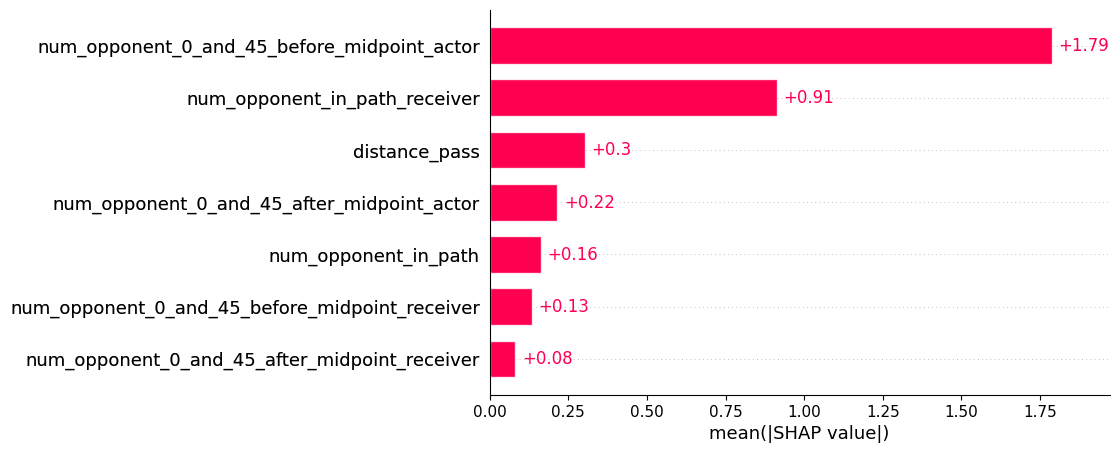

PLAYER ID SRC :  1
COORDINATE SRC :  (42.5, 34.0)
XGOAL VALUE SRC :  0.018084367737174034
PLAYER ID DEST :  2
COORDINATE DEST :  (62.5, 34.0)
XGOAL VALUE DEST :  0.2439076006412506
XPASS/XDRIBBLE VALUE :  0.05516486614942551


In [128]:
path_decision_making_obj = update_xpass_or_xdribble_value_from_path_object(path_decision_making_obj)
path_decision_making_obj = update_xgoal_value_from_path_object(path_decision_making_obj)

route_path = path_decision_making_obj.get_route_path_per_timestamp_map()
for timestamp in sorted(list(route_path_per_timestamp.keys())):
    print("PLAYER ID SRC : ", route_path[timestamp]["source"].get_player_id())
    print("COORDINATE SRC : ", route_path[timestamp]["source"].get_coordinate_value())
    print("XGOAL VALUE SRC : ", route_path[timestamp]["source"].get_xgoal_value())
    print("PLAYER ID DEST : ", route_path[timestamp]["destination"].get_player_id())
    print("COORDINATE DEST : ", route_path[timestamp]["destination"].get_coordinate_value())
    print("XGOAL VALUE DEST : ", route_path[timestamp]["destination"].get_xgoal_value())
    print("XPASS/XDRIBBLE VALUE : ", route_path[timestamp]["pass_or_dribble_prop"])
    print("===========================")

In [129]:
def plot_sequence_probability_per_timestamp(path_decision_making_obj):
    route_path_decision_making = path_decision_making_obj.get_route_path_per_timestamp_map()
    sorted_timestamp_list = sorted(list(route_path_decision_making.keys()))
    opponent_node_list = path_decision_making_obj.get_opponent_state_per_timestamp_map()

    fig, axs = plt.subplots(len(sorted_timestamp_list)+1, 1)
    fig.set_figwidth(100)
    fig.set_figheight(650)

    # Give random color for each player teammate node
    list_color_available_11_players = [
        "#b53a1b", "#ef041a", "#f8b25d",
        "#51c1e3", "#3d21a9", "#b8f56a",
        "#ed5154", "#7d5f40", "#561294",
        "#32075f", "#7000aa"
    ]
    maps_player_id_teammates_and_color_node = {}
    timestamp_final = 0
    player_id_final = 0
    for idx in range(len(sorted_timestamp_list)):
        if (idx == len(sorted_timestamp_list)-1):
            timestamp_final = sorted_timestamp_list[idx]
            player_id_final = route_path_decision_making[sorted_timestamp_list[idx]]["destination"].get_player_id()
        player_id = route_path_decision_making[sorted_timestamp_list[idx]]["source"].get_player_id()
        if player_id not in maps_player_id_teammates_and_color_node:
            index_color_picked = random.randint(0, len(list_color_available_11_players)-1)
            final_color = list_color_available_11_players[index_color_picked]
            del list_color_available_11_players[index_color_picked]
            maps_player_id_teammates_and_color_node[player_id] = final_color
    # Give color to last node element
    if player_id_final not in maps_player_id_teammates_and_color_node:
        index_color_picked = random.randint(0, len(list_color_available_11_players)-1)
        final_color = list_color_available_11_players[index_color_picked]
        del list_color_available_11_players[index_color_picked]
        maps_player_id_teammates_and_color_node[player_id_final] = final_color

    idx_row = 0
    step_number = 1
    current_teammate_nodes_list = []
    current_route_path_list = []

    for timestamp in sorted_timestamp_list:
        pitch = Pitch(pitch_type="custom", pitch_length=105, pitch_width=68, pitch_color="green")
        pitch.draw(axs[idx_row], constrained_layout=True, tight_layout=False, figsize=(300,100))
        axs[idx_row].set_title(f'Scenario for Timestamp {timestamp}', fontsize=150)

        # Get start node player, end node player, and route path this timestamp
        this_route_path = route_path_decision_making[timestamp]
        node_start_player = this_route_path["source"]
        node_end_player = this_route_path["destination"]

        # Initialization for temp variables
        if (idx_row == 0):
            current_teammate_nodes_list.append(node_start_player)
        current_teammate_nodes_list.append(node_end_player)
        current_route_path_list.append(this_route_path)

        # Draw all (current) teammates nodes
        index = 0
        for node in current_teammate_nodes_list:
            start_x, start_y = node.get_coordinate_value()
            player_name = node.get_player_name()
            player_id = node.get_player_id()
            pitch.scatter(x=start_x, y=start_y, c=maps_player_id_teammates_and_color_node[player_id], ax=axs[idx_row], s=20000)
            if (index == len(current_teammate_nodes_list)-1) or (index == 0 and idx_row == 0):
                axs[idx_row].annotate(text=f'{player_name}', xy=(start_x, start_y-5), ha="center", va="center", size=100)
            index += 1

        # Draw all opponent nodes
        if (INCLUDE_OPPONENT):
            for node in opponent_node_list[timestamp]:
                start_x, start_y = node.get_coordinate_value()
                player_name = node.get_player_name()
                player_id = node.get_player_id()
                pitch.scatter(x=start_x, y=start_y, c="black", ax=axs[idx_row], s=20000)
                # axs[idx_row].annotate(text=f'{player_name}', xy=(start_x, start_y-5), ha="center", va="center", size=100)

        # Draw passing/dribbling line
        counter_arrow = 0
        for route_element in current_route_path_list:
            pass_or_dribble_prop = route_element["pass_or_dribble_prop"]
            action_type = route_element["action_type"]
            this_node_player_source = route_element["source"]
            this_node_player_destination = route_element["destination"]

            start_x, start_y = this_node_player_source.get_coordinate_value()
            end_x, end_y = this_node_player_destination.get_coordinate_value()
            pitch.arrows(xstart=start_x, ystart=start_y, xend=end_x, yend=end_y, ax=axs[idx_row], color="black", width=10)
            if counter_arrow == len(current_route_path_list)-1:
                x_line = (start_x + end_x) / 2
                y_line = (start_y + end_y) / 2
                axs[idx_row].annotate(arrowprops=dict(width=10), text="Step " + str(step_number) + ". " + action_type + " : " + str(round(pass_or_dribble_prop, 2)), 
                                    xy=(x_line, y_line), ha="center", va="center", size=100, color="red", xycoords="data", 
                                    textcoords="offset points", xytext=(x_line+500, y_line+500))
            counter_arrow += 1
        idx_row += 1
        step_number += 1

    # # Draw last plot image containing expected goal probability
    # pitch = Pitch(pitch_type="custom", pitch_length=105, pitch_width=68, pitch_color="green")
    # pitch.draw(axs[idx_row], constrained_layout=True, tight_layout=False, figsize=(300,100))
    # axs[idx_row].set_title(f'Scenario for Timestamp {timestamp_final} - Goal Attempt', fontsize=150)

    # # Draw all teammates nodes
    # index = 0
    # for node in current_teammate_nodes_list:
    #     start_x, start_y = node.get_coordinate_value()
    #     player_name = node.get_player_name()
    #     player_id = node.get_player_id()
    #     pitch.scatter(x=start_x, y=start_y, c=maps_player_id_teammates_and_color_node[player_id], ax=axs[idx_row], s=20000)
    #     if (index == len(current_teammate_nodes_list)-1):
    #         axs[idx_row].annotate(text=f'{player_name}', xy=(start_x, start_y-5), ha="center", va="center", size=100)
    #     index += 1

    # # Draw all opponent nodes
    # if (INCLUDE_OPPONENT):
    #     for node in opponent_node_list[timestamp]:
    #         start_x, start_y = node.get_coordinate_value()
    #         player_name = node.get_player_name()
    #         player_id = node.get_player_id()
    #         pitch.scatter(x=start_x, y=start_y, c="black", ax=axs[idx_row], s=20000)
    #         # axs[idx_row].annotate(text=f'{player_name}', xy=(start_x, start_y-5), ha="center", va="center", size=100)

    # # Draw passing/dribbling line
    # for route_element in current_route_path_list:
    #     pass_or_dribble_prop = route_element["pass_or_dribble_prop"]
    #     action_type = route_element["action_type"]
    #     this_node_player_source = route_element["source"]
    #     this_node_player_destination = route_element["destination"]

    #     start_x, start_y = this_node_player_source.get_coordinate_value()
    #     end_x, end_y = this_node_player_destination.get_coordinate_value()
    #     pitch.arrows(xstart=start_x, ystart=start_y, xend=end_x, yend=end_y, ax=axs[idx_row], color="black", width=10)
            
    # # Draw goal probability line
    # node_last_player = route_path_decision_making[timestamp_final]["destination"]
    # goal_prob = node_last_player.get_xgoal_value()
    # start_x, start_y = node_last_player.get_coordinate_value()
    # if (IS_HOME_TEAM_DIRECTION):
    #     end_x = STANDARD_LENGTH_COURT
    # else:
    #     end_x = 0
    # end_y = STANDARD_WIDTH_COURT / 2
    # pitch.arrows(xstart=start_x, ystart=start_y, xend=end_x, yend=end_y, ax=axs[idx_row], color="black", width=10)
    # x_line = (start_x + end_x) / 2
    # y_line = (start_y + end_y) / 2
    # axs[idx_row].annotate(arrowprops=dict(width=10), text="Goal Prob : " + str(round(goal_prob, 2)), 
    #                         xy=(x_line, y_line), ha="center", va="center", size=100, color="red", xycoords="data", 
    #                         textcoords="offset points", xytext=(x_line+500, y_line+500))
    
# Main Program : Draw Plots
# plot_sequence_probability_per_timestamp(path_decision_making_obj)
    

In [130]:
def plot_sequence_probability_without_opponent(path_decision_making_obj):
    route_path_decision_making = path_decision_making_obj.get_route_path_per_timestamp_map()
    sorted_timestamp_list = sorted(list(route_path_decision_making.keys()))
    all_teammates_nodes_available = path_decision_making_obj.get_all_teammates_nodes_not_unique()

    # Give random color for each player teammate node
    list_color_available_11_players = [
        "#b53a1b", "#ef041a", "#f8b25d",
        "#51c1e3", "#3d21a9", "#b8f56a",
        "#ed5154", "#7d5f40", "#561294",
        "#32075f", "#7000aa"
    ]
    maps_player_id_teammates_and_color_node = {}
    timestamp_final = 0
    player_id_final = 0
    for idx in range(len(sorted_timestamp_list)):
        if (idx == len(sorted_timestamp_list)-1):
            timestamp_final = sorted_timestamp_list[idx]
            player_id_final = route_path_decision_making[sorted_timestamp_list[idx]]["destination"].get_player_id()
        player_id = route_path_decision_making[sorted_timestamp_list[idx]]["source"].get_player_id()
        if player_id not in maps_player_id_teammates_and_color_node:
            index_color_picked = random.randint(0, len(list_color_available_11_players)-1)
            final_color = list_color_available_11_players[index_color_picked]
            del list_color_available_11_players[index_color_picked]
            maps_player_id_teammates_and_color_node[player_id] = final_color
    # Give color to last node element
    if player_id_final not in maps_player_id_teammates_and_color_node:
        index_color_picked = random.randint(0, len(list_color_available_11_players)-1)
        final_color = list_color_available_11_players[index_color_picked]
        del list_color_available_11_players[index_color_picked]
        maps_player_id_teammates_and_color_node[player_id_final] = final_color

    pitch = Pitch(pitch_type="custom", pitch_length=105, pitch_width=68, pitch_color="green")
    fig, ax = pitch.draw(figsize=(300,100), constrained_layout=True, tight_layout=False)
    ax.set_title(f'All sequence probability scenario', fontsize=150)

    # Draw all teammates nodes
    for node in all_teammates_nodes_available:
        start_x, start_y = node.get_coordinate_value()
        player_name = node.get_player_name()
        player_id = node.get_player_id()
        pitch.scatter(x=start_x, y=start_y, c=maps_player_id_teammates_and_color_node[player_id], ax=ax, s=30000)
        ax.annotate(text=f'{player_name}', xy=(start_x, start_y-5), ha="center", va="center", size=100)

    step_counter = 0
    for timestamp in sorted_timestamp_list:
        # Draw passing/dribbling line
        node_start_player = route_path_decision_making[timestamp]["source"]
        node_end_player = route_path_decision_making[timestamp]["destination"]
        pass_or_dribble_prop = route_path_decision_making[timestamp]["pass_or_dribble_prop"]
        action_type = route_path_decision_making[timestamp]["action_type"]
        start_x, start_y = node_start_player.get_coordinate_value()
        end_x, end_y = node_end_player.get_coordinate_value()
        pitch.arrows(xstart=start_x, ystart=start_y, xend=end_x, yend=end_y, ax=ax, color="black", width=30)
        x_line = (start_x + end_x) / 2
        y_line = (start_y + end_y) / 2
        ax.annotate(arrowprops=dict(width=10), text="Step " + str(step_counter) + ". " + action_type + " : " + str(round(pass_or_dribble_prop, 2)), 
                    xy=(x_line, y_line), ha="center", va="center", size=150, color="red", xycoords="data", 
                    textcoords="offset points", xytext=(x_line+500, y_line+500))
        step_counter += 1

    # Draw goal probability line
    node_last_player = route_path_decision_making[timestamp_final]["destination"]
    goal_prob = node_last_player.get_xgoal_value()
    start_x, start_y = node_last_player.get_coordinate_value()
    if (IS_HOME_TEAM_DIRECTION):
        end_x = STANDARD_LENGTH_COURT
    else:
        end_x = 0
    end_y = STANDARD_WIDTH_COURT / 2
    pitch.arrows(xstart=start_x, ystart=start_y, xend=end_x, yend=end_y, ax=ax, color="black", width=20)
    x_line = (start_x + end_x) / 2
    y_line = (start_y + end_y) / 2
    ax.annotate(arrowprops=dict(width=10), text="Goal Prob : " + str(round(goal_prob, 2)), 
                xy=(x_line, y_line), ha="center", va="center", size=150, color="red", xycoords="data", 
                textcoords="offset points", xytext=(x_line+500, y_line+500))

# Main Program : Draw Plots
# plot_sequence_probability_without_opponent(path_decision_making_obj)